In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import npts

DATA_DIR = 'data/'

In [2]:
def load_year(year):
    ## Look at the document in DATA_DIR for spec.
    data=pd.read_csv(DATA_DIR+f'{year}-SFO-weather.csv.gz', usecols=[1,13])
    data.index = pd.to_datetime(data.DATE, format='%Y-%m-%dT%H:%M:%S')
    data = data.dropna()
    data['temp'] = data.TMP.apply(lambda el: float(el.split(',')[0])/10.)
    data['qual_code'] = data.TMP.apply(lambda el: (el.split(',')[1]))
    # time zone
    import pytz
    pacific = pytz.timezone('US/Pacific')
    data.index = data.index.tz_localize(pytz.utc).tz_convert(pacific)

    return data.temp[data.qual_code.isin(['1','5'])]

temperatures = pd.Series()
for year in range(1987, 2019):
    temperatures = temperatures.append(load_year(year))

In [3]:
print('we have years:', set(temperatures.index.year))
data_used = temperatures[temperatures.index.year <= 2015]
indep_test = temperatures[temperatures.index.year > 2015]

we have years: {1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018}


In [81]:
MIN_REG = 1E-8 * np.abs(data_used).mean()
MAX_REG = MIN_REG * 1E8

In [103]:
indep_test_rmse = pd.DataFrame()
time_taken = pd.DataFrame()
model_objs = pd.DataFrame()

In [104]:
day_seconds = 86400
tropical_year_seconds = 365.24219 * day_seconds

models_modelnames = [
    [npts.Baseline(), 'const.', 1.],
    [npts.Baseline(npts.HourOfDay(lambdas=[MIN_REG])), 'hour', 1.],
    [npts.Baseline(npts.DayOfYear(lambdas=[MIN_REG])), 'day', 1.],
    [npts.Baseline(npts.HourOfDay(lambdas=[MIN_REG]),
                   npts.DayOfYear(lambdas=[MIN_REG])), 'hour and day', 1.],
    [npts.Baseline(npts.HourOfDay(lambdas=np.logspace(np.log10(MIN_REG),np.log10(MAX_REG), 20)),
                   npts.DayOfYear(lambdas=np.logspace(np.log10(MIN_REG),np.log10(MAX_REG), 20))),
     'hour and day bas.', .75],
    [npts.Harmonic([day_seconds, tropical_year_seconds]), 'hour and day harmonic.', .75]
]

# for el in models_modelnames:
#     el[1] += f' n_par = {el[0].cum_periods[-1] if el[0] is npts.Baseline() else None}'

building reg matrices
building reg matrices
building reg matrices
building reg matrices
building reg matrices


In [105]:
np.random.seed(0)
import time 
import copy

def sparsify_data(data, frac):
    return data[np.random.uniform(size=len(data)) < frac]

for data in [sparsify_data(data_used, target/len(data_used)) for target in (1E6, 1E5, 1E4, 1E3, 1E2)]:
    dataname = f'M = {len(data)}'
    print(dataname)
    for model, modelname, train_frac in models_modelnames:
        print(f'fitting {modelname} using {100*train_frac:.0f}% train data')
        model_used = copy.copy(model)
        model_objs.loc[dataname, modelname] = model_used
        s = time.time()
        model_used.fit(data,train_frac=train_frac)
        time_taken.loc[dataname, modelname] = time.time() - s
        pred = model_used.predict(indep_test.index)
        indep_test_rmse.loc[dataname, modelname] = np.sqrt(np.mean((indep_test - pred)**2)) 

M = 294524
fitting const. using 100% train data
fitting hour using 100% train data
fitting day using 100% train data
fitting hour and day using 100% train data
fitting hour and day bas. using 75% train data
fitting hour and day harmonic. using 75% train data
M = 99926
fitting const. using 100% train data
fitting hour using 100% train data
fitting day using 100% train data
fitting hour and day using 100% train data
fitting hour and day bas. using 75% train data
fitting hour and day harmonic. using 75% train data
M = 9811
fitting const. using 100% train data
fitting hour using 100% train data
fitting day using 100% train data
fitting hour and day using 100% train data
fitting hour and day bas. using 75% train data
fitting hour and day harmonic. using 75% train data
M = 950
fitting const. using 100% train data
fitting hour using 100% train data
fitting day using 100% train data
fitting hour and day using 100% train data
fitting hour and day bas. using 75% train data
fitting hour and day h

In [106]:
indep_test_rmse

,const.,hour,day,hour and day,hour and day bas.,hour and day harmonic.
M = 294524,3.939769,3.400739,3.273765,2.552125,2.545078,2.611945
M = 99926,3.942954,3.405067,3.279334,2.620958,2.551195,2.612170
M = 9811,3.930463,3.394620,3.317456,3.105552,2.558154,2.611201
M = 950,3.959532,3.454447,4.114850,2.992947,2.659182,2.637048
M = 107,3.973400,4.871031,10.916624,14.060608,2.866912,2.616068


In [93]:
model_objs.iloc[2,3].best_lambda

(0.00012348173481150322, 0.0059677861008181274)

In [107]:
print(indep_test_rmse.to_latex(float_format="%.3f"))

\begin{tabular}{lrrrrrr}
\toprule
{} &  const. &  hour &    day &  hour and day &  hour and day bas. &  hour and day harmonic. \\
\midrule
M = 294524 &   3.940 & 3.401 &  3.274 &         2.552 &              2.545 &                   2.612 \\
M = 99926  &   3.943 & 3.405 &  3.279 &         2.621 &              2.551 &                   2.612 \\
M = 9811   &   3.930 & 3.395 &  3.317 &         3.106 &              2.558 &                   2.611 \\
M = 950    &   3.960 & 3.454 &  4.115 &         2.993 &              2.659 &                   2.637 \\
M = 107    &   3.973 & 4.871 & 10.917 &        14.061 &              2.867 &                   2.616 \\
\bottomrule
\end{tabular}



In [95]:
time_taken

,const.,hour,day,hour and day bas.,hour and day harmonic.
M = 294524,1.697919,1.753560,1.776040,15.961296,0.558665
M = 99926,0.563363,0.540087,0.563492,14.162408,0.188418
M = 9811,0.054327,0.051320,0.048374,13.518146,0.033983
M = 950,0.007198,0.007497,0.007914,15.682150,0.021495
M = 107,0.002992,0.003117,0.003265,19.758712,0.020156


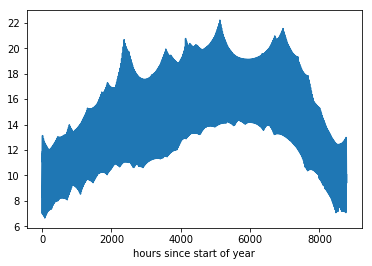

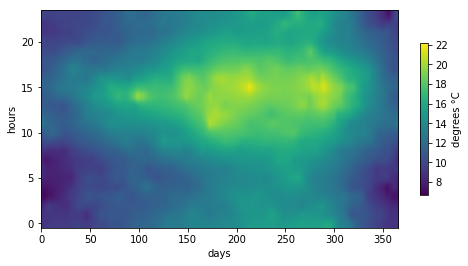

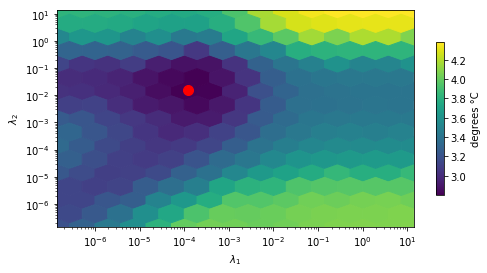

In [112]:
# np.random.seed(0)
# small_data = sparsify_data(data_used, .01)

# baseline_small_data = npts.Baseline(npts.HourOfDay(lambdas=np.logspace(-8,5, 30)), 
#                          npts.DayOfYear(lambdas=np.logspace(-8,5, 30)))

# baseline_small_data.fit(small_data)


baseline_small_data = model_objs.iloc[3,4]

def plot_2d_model(theta):
    
    plt.figure()
    plt.plot(theta)
    plt.xlabel('hours since start of year')

    fig = plt.figure(figsize=(8,4))
    cax = plt.imshow(theta.reshape((366,24)).T, 
                     aspect='auto',origin='lower',interpolation='gaussian')
    axc = fig.colorbar(cax, ax=fig.gca(), shrink=.7, label='degrees °C')
    plt.xlabel('days')
    plt.ylabel('hours')

plot_2d_model(baseline_small_data.theta)
plt.savefig('../fig/temperatures_baseline.pdf')


def plot_RMSE(baseline, cost_dict, title):
    fig = plt.figure(figsize=(8,4))
    cax = plt.hexbin(*np.array([[*k,np.sqrt(v)] for k, v in cost_dict.items() ]).T,
                     xscale='log',
                     yscale='log',
              gridsize=14)
    axc = fig.colorbar(cax, ax=fig.gca(), shrink=.7, label='degrees °C')
    plt.loglog(*baseline.best_lambda, 'ro', markersize=10)
    plt.xlabel('$λ_1$')
    plt.ylabel('$λ_2$')
    #plt.title(title)
    
plot_RMSE(baseline_small_data, baseline_small_data.val_costs, 'RMSE validation set')
plt.savefig('../fig/temperatures_rmse.pdf')